# Coursework: 5 day temperature prediction with time series data

This coursework will build on the work from tutorial 4 which used the 'DailyDelhiClimate' dataset to explore the development of RNN models. The coursework contains 5 tasks each with a number of exercises. The final deliverable of the coursework will be a version of this notebook, including answers to your questions in the appropriate places.

Answers to exercises will take two forms, either code completion or written pros in markdown blocks. Below demonstrates what these will look like:

#### Code completion

In [1]:
# Your code here

# Your code here - END

#### Written pros in markdown

With respect to markdown answers, you may refer to other figures/results/code __within__ the notebook however, this __must__ be stated within the defined answer space. Furthermore, if other figures/results/code are referred to, however, it is not obvious what specific figures/results/code, the references will be discounted from the answer. To load externel images into a jupyter notebook, use the __markdown__ command ```![alt text](<path_to_image_file>)```. And please remember to submit all referenced pictures with your jupyter notebook __within a single zip file__.

__Final points__:
* No marks will be awarded for the performance of models - we are interested in how you approach model development and justify what you are doing!
* There are lots of ways to code something, as long as the code works and produces the desired output, you will be awared full marks (for that question)!

## Setup

In [2]:
gpu = False

# Used for debugging the notebook locally. Leave as False when running in collab!
local_testing = False
if local_testing:
    data_dir = "../../data"
else:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        data_dir = "/content/drive/MyDrive/comp0188/data"
    except ModuleNotFoundError:
        print("This notebook might be running locally!")


Mounted at /content/drive


In [3]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [4]:
import wandb
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from typing import Union, Callable, Tuple, List, Literal, Dict
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import logging
from abc import ABCMeta, abstractmethod

In [5]:
logger = logging.getLogger("coursework_1")
logger.setLevel(logging.INFO)

In [6]:
MODEL_SEED = 1
WANDB_PROJ = "coursework_1"
TMP_DIR = "./tmp"

if os.path.isdir(TMP_DIR):
    pass
else:
    os.mkdir(TMP_DIR)

## Helper functions/classes

In [7]:
class DebugPass:

    def __init__(self):
        self.y_pred = []
        self.y_true = []

    def debug(
        self,
        y_true:torch.tensor,
        y_pred:torch.tensor,
    ):
        pass

    def close(self):
        pass

class DebugBase(DebugPass):

    def __init__(self):
        super().__init__()

    def debug(self, y_true, y_pred):
        self.y_true.append(y_true.detach().numpy())
        self.y_pred.append(y_pred.detach().numpy())

    @abstractmethod
    def close(self):
        pass

class DebugLocal(DebugBase):

    def __init__(self):
        super().__init__()

    def close(self):
        res_tbl = pd.DataFrame(
            {
                "y_true":np.concatenate(self.y_true, axis=0).squeeze().flatten(),
                "y_pred":np.concatenate(self.y_pred, axis=0).squeeze().flatten()
            }
        )
        res_tbl.to_csv(os.path.join(TMP_DIR, "validate_debug.csv"), index=False)

class DebugWandB(DebugBase):

    def __init__(self):
        super().__init__()

    def close(self):
        res_tbl = pd.DataFrame(
            {
                "y_true":np.concatenate(self.y_true, axis=0).squeeze().flatten(),
                "y_pred":np.concatenate(self.y_pred, axis=0).squeeze().flatten()
            }
        )
        wandb_tbl = wandb.Table(dataframe=res_tbl)
        wandb.log({"val_predictions" : wandb_tbl})

def train_single_epoch(model:nn.Module, data_loader:torch.utils.data.DataLoader,
                       gpu:Literal[True, False], optimizer:torch.optim,
                       criterion:torch.nn.modules.loss
                      ) -> Tuple[List[torch.Tensor]]:
    model.train()
    losses = []
    preds = []
    range_gen = tqdm(
        enumerate(data_loader),
        )
    for i, (y,X) in range_gen:

        if gpu:
            X = X.cuda()
            y = y.cuda()
        else:
            X = Variable(X)
            y = Variable(y)

        optimizer.zero_grad()

        # Compute output
        output = model(X)
        preds.append(output)
        train_loss = criterion(output, y)
        losses.append(train_loss.item())

        try:
            train_loss.backward()

            optimizer.step()
        except RuntimeError as e:
            print("Runtime error on training instance: {}".format(i))
            raise e
    return losses, preds

def validate(model:nn.Module, data_loader:torch.utils.data.DataLoader,
             gpu:Literal[True, False], criterion:torch.nn.modules.loss,
             dh:DebugPass
            ) -> Tuple[List[torch.Tensor]]:

    model.eval()
    losses = []
    preds = []
    with torch.no_grad():
        range_gen = tqdm(
            enumerate(data_loader),
        )
        # Your code here
        for i, (y,X) in range_gen:

            if gpu:
                X = X.cuda()
                y = y.cuda()
            else:
                X = Variable(X)
                y = Variable(y)

            # Compute output
            output = model(X)

            # Logs
            losses.append(criterion(output, y).item())
            preds.append(output)
            dh.debug(y_true=y, y_pred=output)
    return losses, preds


def train(model:torch.nn, train_data_loader:torch.utils.data.DataLoader,
          val_data_loader:torch.utils.data.DataLoader,
          gpu:Literal[True, False], optimizer:torch.optim,
          criterion:torch.nn.modules.loss, epochs:int,
          debug:bool = False, wandb_proj:str="",
          wandb_name="", wandb_config:Dict={}
         ) -> Tuple[List[torch.Tensor]]:

    if (len(wandb_config) == 0) or (len(wandb_proj) == 0) or (len(wandb_name) == 0):
        use_wandb = False
        logger.warning("WandB not in use!")
        chkpnt_dir = TMP_DIR
    else:
        use_wandb = True
        wandb.init(project=wandb_proj, config=wandb_config, name=wandb_name)
        chkpnt_dir = wandb.run.dir

    if debug:
        if use_wandb:
            dh = DebugWandB()
        else:
            dh = DebugLocal()
    else:
        dh = DebugPass()

    if gpu:
        model.cuda()

    epoch_train_loss = []
    epoch_val_loss = []
    for epoch in range(1, epochs+1):
        print("Running training epoch")
        train_loss_val, train_preds =  train_single_epoch(
            model=model, data_loader=train_data_loader, gpu=gpu,
            optimizer=optimizer, criterion=criterion)
        mean_train_loss = np.mean(train_loss_val)
        epoch_train_loss.append(mean_train_loss)
        val_loss_val, val_preds = validate(
            model=model, data_loader=val_data_loader, gpu=gpu,
            criterion=criterion, dh=dh)

        print("Running validation")
        mean_val_loss = np.mean(val_loss_val)
        epoch_val_loss.append(np.mean(val_loss_val))

        chkp_pth = os.path.join(chkpnt_dir, f"mdl_chkpnt_epoch_{epoch}.pt")
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, chkp_pth)
        if use_wandb:
            wandb.log({"train_loss": mean_train_loss, "val_loss": mean_val_loss})
            wandb.save(chkp_pth)
    dh.close()
    if use_wandb:
        wandb.finish()
    return epoch_train_loss, epoch_val_loss

In [8]:
class PandasDataset(Dataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, normalise:bool=True)->None:
        # Your code here
        self._X = torch.from_numpy(X.values).float()
        if normalise:
            self._X = self.__min_max_norm(self._X)
        self.feature_dim = X.shape[1]
        self._len = X.shape[0]
        self._y = torch.from_numpy(y.values).float()

    def __len__(self)->int:
        # Your code here
        return self._len

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Your code here
        return self._y[idx], self._X[idx,:]

    def __min_max_norm(self, in_tens:torch.Tensor) -> torch.Tensor:
        _min = in_tens.min(axis=0).values
        _max = in_tens.max(axis=0).values
        in_tens = (in_tens - _min)/(_max - _min)
        return in_tens

class PandasTsDataset(PandasDataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, lookback:int, normalise:bool=True)->None:
        # Call super so that the PandasDataset.__init__ function is called
        super().__init__(X=X, y=y, normalise=normalise)
        if lookback > 1:
            self.get_lookback(lookback=lookback)
        self._len = self._X.shape[0]

    def get_lookback(self, lookback:int):
        X_vals = []
        y_vals = []
        for i in range(self._X.shape[0]-(lookback-1)):
            X_vals.append(self._X[i:i+lookback][None, :])
            y_vals.append(self._y[i+lookback-1:i+lookback])
        self._y = torch.concat(y_vals, axis=0)
        self._X = torch.concat(X_vals, axis=0)


## Data import and visualisation
This section contains code for loading the data and generating different target values. This is the same code that was used in tutorial 4.

In [9]:
train_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTrain.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTest.csv"))
date_var = "date"
train_df[date_var] = pd.to_datetime(train_df[date_var], format="%Y-%m-%d")

# Dynamically select remaining columns
non_date_vars = [col for col in train_df.columns if col != date_var]
# For the training and test set, create a new column per non-date variable for each step number in "steps"
steps = [1,5,10]
for df in [train_df, test_df]:
    for stp in steps:
        df[[f"{col}_{stp}_step" for col in non_date_vars]] = df[non_date_vars].shift(-1*stp)
train_df["__date_yrs"] = train_df["date"].dt.year
# Visualise time periods covered by the training data
print(train_df["__date_yrs"].value_counts())

# Select the time period for the holdout set
val_idx = train_df["__date_yrs"] >= 2016
val_df = train_df[val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
train_df = train_df[~val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
train_df.head()

2016    366
2013    365
2014    365
2015    365
2017      1
Name: __date_yrs, dtype: int64
(1095, 17)
(367, 17)
(114, 17)


,date,meantemp,humidity,wind_speed,meanpressure,meantemp_1_step,humidity_1_step,wind_speed_1_step,meanpressure_1_step,meantemp_5_step,humidity_5_step,wind_speed_5_step,meanpressure_5_step,meantemp_10_step,humidity_10_step,wind_speed_10_step,meanpressure_10_step
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.000000,82.800000,1.480000,1018.000000,15.714286,51.285714,10.571429,1016.142857
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,7.000000,78.600000,6.300000,1020.000000,14.000000,74.000000,13.228571,1015.571429
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667,8.857143,63.714286,7.142857,1018.714286,15.833333,75.166667,4.633333,1013.333333
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000,14.000000,51.250000,12.500000,1017.000000,12.833333,88.166667,0.616667,1015.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000,11.000000,62.000000,7.400000,1015.666667,14.714286,71.857143,0.528571,1015.857143


## Task1: Project assumptions

Before performing any kind of model development, it is critical to define the scope of the model development process. This includes making decisions which stay fixed throughout the rest of the model development as changing them would render model comparisons invalid. For example, comparing two models with test score calculated on different test datasets or with different metrics is meaningless. These decisions are herein referred to as "model development assumptions" and include but are not limited to:
* The split of training/validation and test set;
* Overall model performance metric need to be defined.

Whilst these assumptions can be altered later on in the model development process, they have been sectioned here to emphasise their importance and impact on the subsiquent process i.e., don't be afraid to edit them but understand the impact that this will have on any subsiquent development that you have performed!

__Exercise 1.1__ (1 mark):
* Provide in the code block below a reasonable model performance metric which will be used to report the performance of the baseline model and subsiquent model experiements.
* Justify your choice of criterion. Reference should be made to the theoretical range of values over which the target variable is defined.

In [10]:
# Your code here
ovrl_criterion = nn.MSELoss()
# Your code here - END
trgt_col = ["meantemp_5_step"]

__```ovrl_criterion``` Justification__: My choice of the overall criterion is the `nn.MESLoss` function. The prediction varaiable of this task is the mean temperature 5 days after, so the **Mean Squared Error (MSE)** is a typical and common loss function for evaluating continuous variables. In Pytorch, the MSE Loss is implemented through `nn.MESLoss()`.

## Task2: Baseline model
Now that the project assumptions have been set, a baseline model must be defined to guide the development of more complex models. The baseline model for the task should be of the form $y_{t+5} = b + x_{t}w_{1}^{T} + x_{t-1}w_{2}^{T}$, where:
* $y_{t}$ is vector of dimension (1), represeting the mean temperature at time t
* $x_{t}$ is a vector of dimension (1, 4) representing the mean temperature, mean pressure, etc (note, therefore $y_{t} \in x_{t}$)
* $W_{1}$ and $W_{2}$ are weight vectors of dimension (1, 4) and $b$ is a bias term of dimension (1)

Note, the dimensions above __do not include__ a batch dimension

__Exercise 2.1__ (4 marks):
* Implement the above baseline model in Pytorch

_Hint_:
* Remember, MLPs are just a series of linear regressions chained together with non-linear activations. Given this, what PyTorch module might be useful to use?
* How you would compute $x_{t}w_{1}^{T}$ on paper - this may provide insight into how the above baseline equation can be simplified and implemented in Pytorch
* Remember, for Pytorch models, the ```forward``` method implements the forward pass of the model and _generally speaking_ refers to modules that have been initialised within the class ```__init__```

In [11]:
class BaselineModel(nn.Module):
    def __init__(self, input_dim:int, output_dim:int) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        # Your code here
        self.w1 = nn.Parameter(torch.zeros(1, 4), requires_grad=True)
        self.w2 = nn.Parameter(torch.zeros(1, 4), requires_grad=True)
        self.b = nn.Parameter(torch.zeros(1,), requires_grad=True)
        # Your code here - END

    def forward(self, x:torch.tensor)->torch.tensor:
        # Your code here
        return self.b + torch.sum(x[:, 1, :] * self.w1, dim=-1) +\
                        torch.sum(x[:, 0, :] * self.w2, dim=-1)
        # Your code here - END

__Exercise 2.2__: (1 marks)
* In the code block below, define some reasonable hyperparameters for training your baseline model. For each of the hyperparameters, justify your choices using the markdown block below the code block.

_Hint_:
* ```lookback``` and ```input_dim``` should be set to specific values using information that you have already been provided with
* ```shuffle```, ```batch_size``` and ```lr``` should be set to values deemed reasonable by you.
    * Remember, for __some__ of these parameters, setting a value that is generally understood to work might be a good starting point. However, the hyperparameters chosen need to work for our baseline model!

In [12]:
# Your code here
lookback = 2
input_dim = 4
shuffle = True
batch_size = 16
lr = 1e-3
# Your code here - END
epochs = 100

__WRITTEN ANSWER: ```lookback``` justification__: The hyperparameter `lookback` should be set to 2 as our baseline will take $x_t$ and $x_{t-1}$ as input. 

__WRITTEN ANSWER: ```input_dim``` justification__: The hyperparameter `input_dim` refers to the dimension of each input $x_t$ and $x_{t-1}$ and each $x_i$ contains four real value: `meantemp`, `humidity`, `wind_speed`, and `meanpressure`. Therefore, the hyperparameter `input_dim` should be set as 4.

__WRITTEN ANSWER: ```shuffle``` justification__:  The hyperparameter `shuffle` must be set as `True` for training. During training, with the data loader shuffled, we can provide the model with different batches of data by epochs. This training technique can let the model learn from the data better and can also improve the generalization ability of the model. As for validation or test, shuffling or not will diverse the overall statistics slightly but does not matter so much.

__WRITTEN ANSWER: ```batch_size``` justification__: My choice of `batch_size` is 16, which is relatively a small number. Choosing a batch size as some power of 2 can utilise the CPU/GPU memory more efficiently, thus leading to faster computation. I do test different settings of batch size from 16 to 64, and it seems to have some connections of the `learning rate`, and finally I kept the batch size as 16.

__WRITTEN ANSWER: ```lr``` justification__: Since we will use the Adam optimizer to update the model parameters, the default value of learning rate according to the [pytorch document](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is `0.001`. I have tested some combinations of the `batch_size` and `lr` to control the 'speed' of parameter updates. Finally, I decided to use the default value `0.001` as my learning rate in the following task.

In [13]:
train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[trgt_col], lookback=lookback)
val_idx = val_df[trgt_col].isna().sum(axis=1) != 1
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

In [14]:
wandb_config={
    "lr": lr,
    "lookback": lookback,
}

model = BaselineModel(input_dim=input_dim, output_dim=1)

# Check model parameters
for param in model.named_parameters():
    print(f"Param: {param[0]}")
    print(f"Param shape: {param[1].shape}")
    print("\n")

# Check model is predicting
with torch.no_grad():
    first_batch = next(train_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="baseline", wandb_config=wandb_config, debug=False
)
baseline_epoch_train_loss, baseline_epoch_val_loss = epoch_train_loss, epoch_val_loss

Param: w1
Param shape: torch.Size([1, 4])


Param: w2
Param shape: torch.Size([1, 4])


Param: b
Param shape: torch.Size([1])


first_batch res shape: torch.Size([16, 1])
res shape: torch.Size([16])


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running training epoch


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
51it [00:00, 132.07it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
69it [00:00, 134.97it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])). This will likely lead to incorrect results due t

Running validation
Running training epoch


69it [00:00, 248.08it/s]
23it [00:00, 1019.44it/s]


Running validation
Running training epoch


69it [00:00, 402.72it/s]
23it [00:00, 489.03it/s]


Running validation
Running training epoch


69it [00:00, 293.07it/s]
23it [00:00, 754.24it/s]


Running validation
Running training epoch


69it [00:00, 413.10it/s]
23it [00:00, 1268.68it/s]


Running validation
Running training epoch


69it [00:00, 198.11it/s]
23it [00:00, 477.91it/s]


Running validation
Running training epoch


69it [00:00, 149.07it/s]
23it [00:00, 401.43it/s]


Running validation
Running training epoch


69it [00:00, 103.29it/s]
23it [00:00, 372.71it/s]


Running validation
Running training epoch


69it [00:00, 128.95it/s]
23it [00:00, 402.38it/s]


Running validation
Running training epoch


69it [00:00, 167.52it/s]
23it [00:00, 621.64it/s]


Running validation
Running training epoch


69it [00:00, 144.75it/s]
23it [00:00, 382.63it/s]


Running validation
Running training epoch


69it [00:00, 155.71it/s]
23it [00:00, 405.48it/s]


Running validation
Running training epoch


69it [00:00, 289.43it/s]
23it [00:00, 592.21it/s]


Running validation
Running training epoch


69it [00:00, 132.91it/s]
23it [00:00, 308.91it/s]


Running validation
Running training epoch


69it [00:00, 243.73it/s]
23it [00:00, 434.09it/s]


Running validation
Running training epoch


69it [00:00, 144.86it/s]
23it [00:00, 603.31it/s]


Running validation
Running training epoch


69it [00:00, 135.25it/s]
23it [00:00, 424.80it/s]


Running validation
Running training epoch


69it [00:00, 168.11it/s]
23it [00:00, 685.38it/s]


Running validation
Running training epoch


69it [00:00, 228.26it/s]
23it [00:00, 1329.40it/s]


Running validation
Running training epoch


69it [00:00, 197.56it/s]
23it [00:00, 1289.43it/s]


Running validation
Running training epoch


69it [00:00, 209.54it/s]
23it [00:00, 576.67it/s]


Running validation
Running training epoch


69it [00:00, 332.81it/s]
23it [00:00, 1275.86it/s]


Running validation
Running training epoch


69it [00:00, 244.95it/s]
23it [00:00, 470.86it/s]


Running validation
Running training epoch


69it [00:00, 390.75it/s]
23it [00:00, 554.25it/s]


Running validation
Running training epoch


69it [00:00, 272.68it/s]
23it [00:00, 1380.87it/s]


Running validation
Running training epoch


69it [00:00, 233.67it/s]
23it [00:00, 567.42it/s]


Running validation
Running training epoch


69it [00:00, 195.31it/s]
23it [00:00, 1359.69it/s]


Running validation
Running training epoch


69it [00:00, 234.36it/s]
23it [00:00, 913.61it/s]


Running validation
Running training epoch


69it [00:00, 250.63it/s]
23it [00:00, 822.41it/s]


Running validation
Running training epoch


69it [00:00, 244.83it/s]
23it [00:00, 1011.35it/s]


Running validation
Running training epoch


69it [00:00, 314.08it/s]
23it [00:00, 870.31it/s]


Running validation
Running training epoch


69it [00:00, 360.40it/s]
23it [00:00, 503.46it/s]


Running validation
Running training epoch


69it [00:00, 267.85it/s]
23it [00:00, 1196.63it/s]


Running validation
Running training epoch


69it [00:00, 284.33it/s]
23it [00:00, 592.70it/s]


Running validation
Running training epoch


69it [00:00, 305.95it/s]
23it [00:00, 316.89it/s]


Running validation
Running training epoch


69it [00:00, 255.36it/s]
23it [00:00, 1324.47it/s]


Running validation
Running training epoch


69it [00:00, 321.93it/s]
23it [00:00, 1169.34it/s]


Running validation
Running training epoch


69it [00:00, 224.03it/s]
23it [00:00, 381.33it/s]


Running validation
Running training epoch


69it [00:00, 209.59it/s]
23it [00:00, 445.37it/s]


Running validation
Running training epoch


69it [00:00, 236.38it/s]
23it [00:00, 1394.99it/s]


Running validation
Running training epoch


69it [00:00, 448.29it/s]
23it [00:00, 654.45it/s]


Running validation
Running training epoch


69it [00:00, 325.57it/s]
23it [00:00, 874.91it/s]


Running validation
Running training epoch


69it [00:00, 376.33it/s]
23it [00:00, 326.88it/s]


Running validation
Running training epoch


69it [00:00, 162.65it/s]
23it [00:00, 418.31it/s]


Running validation
Running training epoch


69it [00:00, 286.09it/s]
23it [00:00, 1025.34it/s]


Running validation
Running training epoch


69it [00:00, 266.26it/s]
23it [00:00, 1188.28it/s]


Running validation
Running training epoch


69it [00:00, 121.48it/s]
23it [00:00, 566.43it/s]


Running validation
Running training epoch


69it [00:01, 62.10it/s]
23it [00:00, 143.98it/s]


Running validation
Running training epoch


69it [00:00, 108.39it/s]
23it [00:00, 297.74it/s]


Running validation
Running training epoch


69it [00:00, 210.13it/s]
23it [00:00, 380.20it/s]


Running validation
Running training epoch


69it [00:00, 122.07it/s]
23it [00:00, 1343.92it/s]


Running validation
Running training epoch


69it [00:00, 472.69it/s]
23it [00:00, 1297.60it/s]


Running validation
Running training epoch


69it [00:00, 528.19it/s]
23it [00:00, 1347.37it/s]


Running validation
Running training epoch


69it [00:00, 520.34it/s]
23it [00:00, 1217.32it/s]


Running validation
Running training epoch


69it [00:00, 487.55it/s]
23it [00:00, 962.50it/s]

Running validation


Running training epoch


69it [00:00, 447.05it/s]
23it [00:00, 1347.01it/s]


Running validation
Running training epoch


69it [00:00, 415.74it/s]
23it [00:00, 1253.92it/s]


Running validation
Running training epoch


69it [00:00, 436.23it/s]
23it [00:00, 1087.58it/s]


Running validation
Running training epoch


69it [00:00, 475.46it/s]
23it [00:00, 863.31it/s]


Running validation
Running training epoch


69it [00:00, 386.78it/s]
23it [00:00, 1005.49it/s]


Running validation
Running training epoch


69it [00:00, 417.39it/s]
23it [00:00, 1129.23it/s]


Running validation
Running training epoch


69it [00:00, 252.29it/s]
23it [00:00, 673.84it/s]


Running validation
Running training epoch


69it [00:00, 294.08it/s]
23it [00:00, 453.76it/s]


Running validation
Running training epoch


69it [00:00, 349.11it/s]
23it [00:00, 1068.53it/s]


Running validation
Running training epoch


69it [00:00, 403.27it/s]
23it [00:00, 1534.81it/s]


Running validation
Running training epoch


69it [00:00, 705.66it/s]
23it [00:00, 1616.71it/s]


Running validation
Running training epoch


69it [00:00, 763.08it/s]
23it [00:00, 1365.76it/s]


Running validation
Running training epoch


69it [00:00, 686.71it/s]
23it [00:00, 1652.15it/s]


Running validation
Running training epoch


69it [00:00, 606.03it/s]
23it [00:00, 1274.63it/s]


Running validation
Running training epoch


69it [00:00, 602.59it/s]
23it [00:00, 1675.07it/s]


Running validation
Running training epoch


69it [00:00, 633.94it/s]
23it [00:00, 1642.28it/s]


Running validation
Running training epoch


69it [00:00, 685.61it/s]
23it [00:00, 1109.72it/s]


Running validation
Running training epoch


69it [00:00, 692.88it/s]
23it [00:00, 1457.70it/s]


Running validation
Running training epoch


69it [00:00, 692.36it/s]
23it [00:00, 1476.87it/s]


Running validation
Running training epoch


69it [00:00, 730.49it/s]
23it [00:00, 1505.49it/s]


Running validation
Running training epoch


69it [00:00, 659.33it/s]
23it [00:00, 1209.72it/s]


Running validation
Running training epoch


69it [00:00, 582.58it/s]
23it [00:00, 1377.32it/s]


Running validation
Running training epoch


69it [00:00, 683.82it/s]
23it [00:00, 1355.76it/s]


Running validation
Running training epoch


69it [00:00, 509.50it/s]
23it [00:00, 1261.43it/s]


Running validation
Running training epoch


69it [00:00, 474.99it/s]
23it [00:00, 1198.30it/s]


Running validation
Running training epoch


69it [00:00, 408.92it/s]
23it [00:00, 1296.85it/s]


Running validation
Running training epoch


69it [00:00, 707.72it/s]
23it [00:00, 1520.51it/s]


Running validation
Running training epoch


69it [00:00, 551.92it/s]
23it [00:00, 1230.13it/s]


Running validation
Running training epoch


69it [00:00, 396.46it/s]
23it [00:00, 1239.31it/s]


Running validation
Running training epoch


69it [00:00, 436.92it/s]
23it [00:00, 1073.15it/s]


Running validation
Running training epoch


69it [00:00, 719.48it/s]
23it [00:00, 1352.19it/s]


Running validation
Running training epoch


69it [00:00, 694.48it/s]
23it [00:00, 1473.10it/s]


Running validation
Running training epoch


69it [00:00, 594.91it/s]
23it [00:00, 1222.07it/s]


Running validation
Running training epoch


69it [00:00, 572.31it/s]
23it [00:00, 1496.41it/s]


Running validation
Running training epoch


69it [00:00, 662.72it/s]
23it [00:00, 1553.22it/s]


Running validation
Running training epoch


69it [00:00, 740.96it/s]
23it [00:00, 1108.38it/s]


Running validation
Running training epoch


69it [00:00, 702.09it/s]
23it [00:00, 1438.85it/s]


Running validation
Running training epoch


69it [00:00, 666.16it/s]
23it [00:00, 1237.64it/s]


Running validation
Running training epoch


69it [00:00, 387.19it/s]
23it [00:00, 1701.93it/s]


Running validation
Running training epoch


69it [00:00, 602.75it/s]
23it [00:00, 1654.98it/s]


Running validation
Running training epoch


69it [00:00, 610.41it/s]
23it [00:00, 1394.10it/s]


Running validation
Running training epoch


69it [00:00, 722.93it/s]
23it [00:00, 1268.84it/s]


Running validation
Running training epoch


69it [00:00, 598.82it/s]
23it [00:00, 1555.10it/s]


Running validation
Running training epoch


69it [00:00, 665.62it/s]
23it [00:00, 1046.51it/s]


Running validation
Running training epoch


69it [00:00, 563.32it/s]
23it [00:00, 1642.81it/s]


Running validation


train_loss,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,60.62251
val_loss,97.49898


## Task3: First deep learning model

Given the sequential nature of dataset, an RNN model will be developed for the first stage of the model development process. The ```VanillaRNN``` class below defines such a model blueprint.

In [15]:
class VanillaRNN(nn.Module):

    def __init__(self, input_dim:int,  hidden_dim:int, num_layers:int,
                 fc_output_size:int, *args, **kwargs) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        self._num_layers = num_layers
        self._hidden_dim = hidden_dim
        self.rnn = nn.RNN(
            input_size=input_dim,  hidden_size=hidden_dim,
            num_layers=num_layers, *args, **kwargs,
            batch_first=True
        )
        self.fc = nn.Linear(in_features=hidden_dim, out_features=fc_output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        return self.fc(out[1].squeeze())

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden


__Exercise 3.1:__ (1 marks)
* Complete the code block below, defining the hyperparameters which will be used to define a model of type ```VanillaRNN``` according to the following model specification:
    * A hidden dimension of 64;
    * A single RNN layer with a linear output head and;
    * Relu activations

In [16]:
# Your code here
input_dim = 4
hidden_dim = 64
num_layers = 1
nonlinearity = 'relu'
# Your code here - END
fc_output_size = len(trgt_col)

In [17]:
wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "nonlinearity": nonlinearity,
    "fc_output_size": fc_output_size
}

model = VanillaRNN(
    input_dim=input_dim,  hidden_dim=wandb_config["hidden_dim"],
    num_layers=wandb_config["num_layers"], fc_output_size=wandb_config["fc_output_size"],
    nonlinearity=wandb_config["nonlinearity"]
)

first_batch = next(train_loader.__iter__())
with torch.no_grad():
    print(first_batch[0].shape)
    print(model(first_batch[1]).shape)

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="vanillaRNN", wandb_config=wandb_config, debug=False
)
vanilla_rnn_epoch_train_loss, vanilla_rnn_epoch_val_loss = epoch_train_loss, epoch_val_loss

wandb: Currently logged in as: whynot_s. Use `wandb login --relogin` to force relogin


torch.Size([16, 1])
torch.Size([16, 1])


Running training epoch


69it [00:00, 133.79it/s]
23it [00:00, 389.77it/s]


Running validation
Running training epoch


69it [00:00, 127.74it/s]
23it [00:00, 972.69it/s]


Running validation
Running training epoch


69it [00:00, 266.49it/s]
23it [00:00, 912.93it/s]


Running validation
Running training epoch


69it [00:00, 233.11it/s]
23it [00:00, 425.34it/s]


Running validation
Running training epoch


69it [00:00, 208.41it/s]
23it [00:00, 939.08it/s]


Running validation
Running training epoch


69it [00:00, 295.68it/s]
23it [00:00, 881.46it/s]


Running validation
Running training epoch


69it [00:00, 272.83it/s]
23it [00:00, 959.04it/s]


Running validation
Running training epoch


69it [00:00, 277.62it/s]
23it [00:00, 871.96it/s]


Running validation
Running training epoch


69it [00:00, 294.14it/s]
23it [00:00, 986.61it/s]


Running validation
Running training epoch


69it [00:00, 311.33it/s]
23it [00:00, 927.58it/s]


Running validation
Running training epoch


69it [00:00, 279.85it/s]
23it [00:00, 907.71it/s]


Running validation
Running training epoch


69it [00:00, 259.92it/s]
23it [00:00, 993.91it/s]


Running validation
Running training epoch


69it [00:00, 283.54it/s]
23it [00:00, 796.40it/s]


Running validation
Running training epoch


69it [00:00, 249.81it/s]
23it [00:00, 917.34it/s]


Running validation
Running training epoch


69it [00:00, 257.13it/s]
23it [00:00, 921.31it/s]


Running validation
Running training epoch


69it [00:00, 270.28it/s]
23it [00:00, 902.30it/s]


Running validation
Running training epoch


69it [00:00, 252.29it/s]
23it [00:00, 742.52it/s]


Running validation
Running training epoch


69it [00:00, 286.17it/s]
23it [00:00, 1185.31it/s]


Running validation
Running training epoch


69it [00:00, 396.73it/s]
23it [00:00, 1321.96it/s]


Running validation
Running training epoch


69it [00:00, 414.14it/s]
23it [00:00, 1309.24it/s]


Running validation
Running training epoch


69it [00:00, 388.29it/s]
23it [00:00, 1204.58it/s]


Running validation
Running training epoch


69it [00:00, 396.83it/s]
23it [00:00, 1043.70it/s]


Running validation
Running training epoch


69it [00:00, 409.75it/s]
23it [00:00, 1290.59it/s]


Running validation
Running training epoch


69it [00:00, 384.29it/s]
23it [00:00, 1358.58it/s]


Running validation
Running training epoch


69it [00:00, 362.36it/s]
23it [00:00, 1241.65it/s]


Running validation
Running training epoch


69it [00:00, 384.52it/s]
23it [00:00, 1332.24it/s]


Running validation
Running training epoch


69it [00:00, 386.10it/s]
23it [00:00, 1129.90it/s]


Running validation
Running training epoch


69it [00:00, 438.65it/s]
23it [00:00, 1236.39it/s]


Running validation
Running training epoch


69it [00:00, 410.12it/s]
23it [00:00, 1147.10it/s]


Running validation
Running training epoch


69it [00:00, 371.91it/s]
23it [00:00, 1018.71it/s]


Running validation
Running training epoch


69it [00:00, 393.68it/s]
23it [00:00, 1326.96it/s]


Running validation
Running training epoch


69it [00:00, 412.20it/s]
23it [00:00, 1261.40it/s]


Running validation
Running training epoch


69it [00:00, 414.37it/s]
23it [00:00, 1267.93it/s]


Running validation
Running training epoch


69it [00:00, 405.70it/s]
23it [00:00, 1124.79it/s]


Running validation
Running training epoch


69it [00:00, 385.15it/s]
23it [00:00, 1311.49it/s]


Running validation
Running training epoch


69it [00:00, 391.07it/s]
23it [00:00, 1114.82it/s]


Running validation
Running training epoch


69it [00:00, 379.12it/s]
23it [00:00, 1263.66it/s]


Running validation
Running training epoch


69it [00:00, 376.52it/s]
23it [00:00, 1246.42it/s]


Running validation
Running training epoch


69it [00:00, 370.14it/s]
23it [00:00, 1126.11it/s]


Running validation
Running training epoch


69it [00:00, 401.25it/s]
23it [00:00, 1209.29it/s]


Running validation
Running training epoch


69it [00:00, 414.58it/s]
23it [00:00, 1191.68it/s]


Running validation
Running training epoch


69it [00:00, 418.97it/s]
23it [00:00, 1004.94it/s]


Running validation
Running training epoch


69it [00:00, 386.41it/s]
23it [00:00, 1262.62it/s]


Running validation
Running training epoch


69it [00:00, 355.36it/s]
23it [00:00, 863.85it/s]


Running validation
Running training epoch


69it [00:00, 395.56it/s]
23it [00:00, 1357.25it/s]


Running validation
Running training epoch


69it [00:00, 412.18it/s]
23it [00:00, 1330.15it/s]


Running validation
Running training epoch


69it [00:00, 394.41it/s]
23it [00:00, 1053.70it/s]


Running validation
Running training epoch


69it [00:00, 354.68it/s]
23it [00:00, 1310.04it/s]


Running validation
Running training epoch


69it [00:00, 430.44it/s]
23it [00:00, 1401.00it/s]


Running validation
Running training epoch


69it [00:00, 420.20it/s]
23it [00:00, 1282.95it/s]


Running validation
Running training epoch


69it [00:00, 434.53it/s]
23it [00:00, 1181.93it/s]


Running validation
Running training epoch


69it [00:00, 388.83it/s]
23it [00:00, 1312.47it/s]


Running validation
Running training epoch


69it [00:00, 375.13it/s]
23it [00:00, 1356.20it/s]


Running validation
Running training epoch


69it [00:00, 413.63it/s]
23it [00:00, 1085.75it/s]


Running validation
Running training epoch


69it [00:00, 433.05it/s]
23it [00:00, 1211.30it/s]


Running validation
Running training epoch


69it [00:00, 409.77it/s]
23it [00:00, 1024.40it/s]


Running validation
Running training epoch


69it [00:00, 369.82it/s]
23it [00:00, 870.75it/s]


Running validation
Running training epoch


69it [00:00, 386.06it/s]
23it [00:00, 1212.36it/s]


Running validation
Running training epoch


69it [00:00, 392.99it/s]
23it [00:00, 1409.01it/s]


Running validation
Running training epoch


69it [00:00, 399.63it/s]
23it [00:00, 1087.16it/s]


Running validation
Running training epoch


69it [00:00, 403.91it/s]
23it [00:00, 1222.92it/s]


Running validation
Running training epoch


69it [00:00, 351.73it/s]
23it [00:00, 722.87it/s]


Running validation
Running training epoch


69it [00:00, 256.30it/s]
23it [00:00, 695.76it/s]


Running validation
Running training epoch


69it [00:00, 271.89it/s]
23it [00:00, 892.67it/s]


Running validation
Running training epoch


69it [00:00, 272.51it/s]
23it [00:00, 798.35it/s]


Running validation
Running training epoch


69it [00:00, 282.05it/s]
23it [00:00, 900.70it/s]


Running validation
Running training epoch


69it [00:00, 275.16it/s]
23it [00:00, 986.38it/s]


Running validation
Running training epoch


69it [00:00, 274.25it/s]
23it [00:00, 978.87it/s]


Running validation
Running training epoch


69it [00:00, 254.28it/s]
23it [00:00, 884.40it/s]


Running validation
Running training epoch


69it [00:00, 272.55it/s]
23it [00:00, 884.25it/s]


Running validation
Running training epoch


69it [00:00, 273.25it/s]
23it [00:00, 844.47it/s]


Running validation
Running training epoch


69it [00:00, 260.70it/s]
23it [00:00, 936.25it/s]


Running validation
Running training epoch


69it [00:00, 277.08it/s]
23it [00:00, 915.38it/s]


Running validation
Running training epoch


69it [00:00, 268.84it/s]
23it [00:00, 978.06it/s]


Running validation
Running training epoch


69it [00:00, 253.37it/s]
23it [00:00, 678.25it/s]


Running validation
Running training epoch


69it [00:00, 267.82it/s]
23it [00:00, 938.30it/s]


Running validation
Running training epoch


69it [00:00, 278.15it/s]
23it [00:00, 721.64it/s]


Running validation
Running training epoch


69it [00:00, 271.38it/s]
23it [00:00, 806.46it/s]


Running validation
Running training epoch


69it [00:00, 239.26it/s]
23it [00:00, 899.63it/s]


Running validation
Running training epoch


69it [00:00, 247.81it/s]
23it [00:00, 870.08it/s]


Running validation
Running training epoch


69it [00:00, 247.30it/s]
23it [00:00, 832.89it/s]


Running validation
Running training epoch


69it [00:00, 224.77it/s]
23it [00:00, 775.38it/s]


Running validation
Running training epoch


69it [00:00, 286.91it/s]
23it [00:00, 910.44it/s]


Running validation
Running training epoch


69it [00:00, 353.41it/s]
23it [00:00, 1088.13it/s]


Running validation
Running training epoch


69it [00:00, 334.71it/s]
23it [00:00, 1124.03it/s]


Running validation
Running training epoch


69it [00:00, 324.53it/s]
23it [00:00, 1357.19it/s]


Running validation
Running training epoch


69it [00:00, 374.07it/s]
23it [00:00, 990.09it/s]


Running validation
Running training epoch


69it [00:00, 395.55it/s]
23it [00:00, 1305.65it/s]


Running validation
Running training epoch


69it [00:00, 384.98it/s]
23it [00:00, 1162.03it/s]


Running validation
Running training epoch


69it [00:00, 369.32it/s]
23it [00:00, 1206.33it/s]


Running validation
Running training epoch


69it [00:00, 376.08it/s]
23it [00:00, 1058.24it/s]


Running validation
Running training epoch


69it [00:00, 351.15it/s]
23it [00:00, 1270.06it/s]


Running validation
Running training epoch


69it [00:00, 393.86it/s]
23it [00:00, 1026.08it/s]


Running validation
Running training epoch


69it [00:00, 388.34it/s]
23it [00:00, 1006.85it/s]


Running validation
Running training epoch


69it [00:00, 379.58it/s]
23it [00:00, 1161.07it/s]


Running validation
Running training epoch


69it [00:00, 383.35it/s]
23it [00:00, 1040.07it/s]


Running validation
Running training epoch


69it [00:00, 386.64it/s]
23it [00:00, 1428.87it/s]


Running validation
Running training epoch


69it [00:00, 385.90it/s]
23it [00:00, 922.77it/s]


Running validation
Running training epoch


69it [00:00, 381.16it/s]
23it [00:00, 1038.42it/s]


Running validation
Running training epoch


69it [00:00, 408.15it/s]
23it [00:00, 1219.72it/s]


Running validation


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,6.98593
val_loss,9.99758


__Exercise 3.2:__ (4 marks)
* Using relevant visualisations and/or statistical tests, discuss the relative performance of the Baseline model and VanillaRNN model. Conclude whether an RNN architecture should be used for this modelling task (based __only__ on the previously mentioned visualisations or statistical tests). __No marks__ will be awarded for justifications based on the sequential nature of the data.
* Choose an appropriate epoch for each model and report the difference in performance on the validation set. Justify why you chose the epochs you did for each model.

__WRITTEN ANSWER VanillaRNN performance vs baseline__: According to the top 2 figures below the next cell, the training and validation losses of the Baseline and Vanilla RNN can be clearly compared. Both the training and validation losses of the Vanilla RNN are far less than those of the baseline. Also, the Vanilla RNN converges much faster than the Baseline. These two experimental results demonstrated that an RNN structure is much more suitable for this modelling task.


__WRITTEN ANSWER best epoch and difference in performance__: The best epoch numbers for the Baseline and the Vanilla RNN are **100** and **25** respectively. Based on the bottom 2 figures below the next cell, within 100 epochs, each model has the lowest validation loss when it reaches its best epoch number.


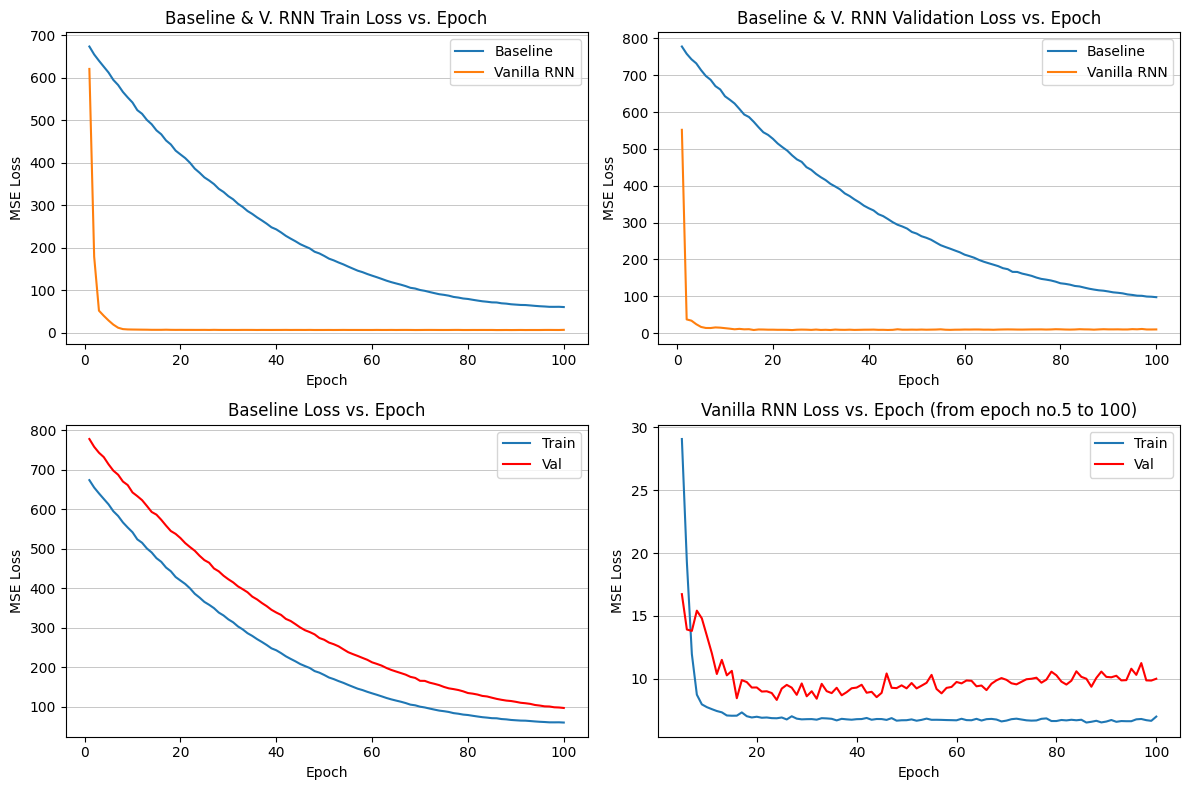

In [18]:
# Creating 1x2 subplots
fig, ((ax5, ax7), (ax1, ax3)) = plt.subplots(2, 2, figsize=(12,8))

# Plotting baseline & vanilla rnn train loss on the left side
# ax6 = ax5.twinx()
lns5 = ax5.plot(range(1, epochs+1), baseline_epoch_train_loss, label="Baseline")
lns6 = ax5.plot(range(1, epochs+1), vanilla_rnn_epoch_train_loss, label="Vanilla RNN")
ax5.set_xlabel("Epoch")
ax5.set_ylabel("MSE Loss")
lns = lns5 + lns6
labs = [l.get_label() for l in lns]
ax5.legend(lns, labs, loc=0)
ax5.set_title("Baseline & V. RNN Train Loss vs. Epoch")
ax5.grid(linewidth=0.5, axis="y")

# Plotting baseline & vanilla rnn validation loss on the left side
# ax8 = ax7.twinx()
lns7 = ax7.plot(range(1, epochs+1), baseline_epoch_val_loss, label="Baseline")
lns8 = ax7.plot(range(1, epochs+1), vanilla_rnn_epoch_val_loss, label="Vanilla RNN")
ax7.set_xlabel("Epoch")
ax7.set_ylabel("MSE Loss")
lns = lns7 + lns8
labs = [l.get_label() for l in lns]
ax7.legend(lns, labs, loc=0)
ax7.set_title("Baseline & V. RNN Validation Loss vs. Epoch")
ax7.grid(linewidth=0.5, axis="y")

# Plotting baseline loss on the left side
# ax2 = ax1.twinx()
lns1 = ax1.plot(range(1, epochs+1), baseline_epoch_train_loss, label="Train")
lns2 = ax1.plot(range(1, epochs+1), baseline_epoch_val_loss, label="Val", c="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_title("Baseline Loss vs. Epoch")
ax1.grid(linewidth=0.5, axis="y")

# Plotting vanilla rnn loss on the right side
# ax4 = ax3.twinx()
min_epochs, max_epochs = 5, epochs
lns3 = ax3.plot(range(min_epochs, max_epochs+1), vanilla_rnn_epoch_train_loss[min_epochs-1:max_epochs], label="Train")
lns4 = ax3.plot(range(min_epochs, max_epochs+1), vanilla_rnn_epoch_val_loss[min_epochs-1:max_epochs], label="Val", c="red")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("MSE Loss")
lns = lns3 + lns4
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.set_title("Vanilla RNN Loss vs. Epoch (from epoch no.%s to %s)" % (min_epochs, max_epochs))
ax3.grid(linewidth=0.5, axis="y")

plt.tight_layout()
plt.show()

## Task4: RNN experimentation

It is hypothesised that the VanillaRNN model can be improved.

__Exercise 4.1__: (4 marks)

Devise an experiment to develop another RNN model making a _single_ change to the VanillaRNN model. This change may include (but is not limited to):
* Swapping the linear head to a non-linear MLP;
* Altering hyperparameters such as the learning rate;
* Increasing the depth of the RNN unit etc.

The ```ExtendedRNN``` class below is used later in the code however, you may choose to use it for implementing your experiment here as it allows MLP heads to be easily implemented.

Complete the markdown block below. You experiment hypothesis must:
* Reference clearly the change you will make;
* Reference relavent evidence from the previous model runs as to why you believe implementing this change will _improve_ the performance of the ```VanillaRNN``` model.

__WRITTEN ANSWER experiment hypothesis__:
* Change to be made: I swapped the linear head to a non-linear MLP, setting the output layer from *64->1* to *64->64->32->1*
* Justification: The Vanilla RNN utilises a single linear layer as the output layer but this setting has some limitations. Mapping 64-dimension vector to one value is more difficult than mapping a lower-dimension one, and this linear mapping only performs well with linear data. Therefore, by adding more fully connected layers with non-linear activation after rnn, we can enhance the capability of the model.

In [19]:
class ExtendedRNN(nn.Module):

    def __init__(
        self, input_dim:int,  rnn_hidden_dim:int, rnn_num_layers:int,
        fc_head_layers:List[int], nonlinearity:str
    ) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        self._num_layers = rnn_num_layers
        self._hidden_dim = rnn_hidden_dim
        self.rnn = nn.RNN(
            input_size=input_dim,  hidden_size=self._hidden_dim,
            num_layers=self._num_layers, nonlinearity=nonlinearity,
            batch_first=True
        )
        if nonlinearity == "relu":
            self.fc_non_linear = nn.ReLU()
        else:
            self.fc_non_linear = nn.Tanh()
        self.fc = nn.ModuleList()
        fc_head_layers = [self._hidden_dim, *fc_head_layers]
        for i in range(len(fc_head_layers)-1):
            self.fc.append(nn.Linear(in_features=fc_head_layers[i], out_features=fc_head_layers[i+1]))
            if i < len(fc_head_layers)-2:
                self.fc.append(self.fc_non_linear)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        out = out[1].squeeze()
        for layer in self.fc:
            out = layer(out)
        if not self.training:
            out = out[:,0][:, None]
        return out


    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden



__Exercise 4.2__: (3 marks)
* Implement your proposed experiment in the code block below.

_Hint_:
* It is __strongly__ suggested that all elements of the experiment be redefined within the __single__ codeblock below, including (but not limited to): input dimensions, target variable, input datasets and dataloaders. Since object names are reused throughout this jupyter notebook, defining all objects (not classes or functions) within the same codeblock will ensure that object names describe the objects you expect!

In [20]:
# Your code here
lookback = 2
input_dim = 4
shuffle = True
batch_size = 16
lr = 1e-3
epochs = 100

train_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTrain.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTest.csv"))
date_var = "date"
train_df[date_var] = pd.to_datetime(train_df[date_var], format="%Y-%m-%d")

# Dynamically select remaining columns
non_date_vars = [col for col in train_df.columns if col != date_var]
# For the training and test set, create a new column per non-date variable for each step number in "steps"
steps = [1,5,10]
for df in [train_df, test_df]:
    for stp in steps:
        df[[f"{col}_{stp}_step" for col in non_date_vars]] = df[non_date_vars].shift(-1*stp)
train_df["__date_yrs"] = train_df["date"].dt.year
# Visualise time periods covered by the training data

# Select the time period for the holdout set
val_idx = train_df["__date_yrs"] >= 2016
val_df = train_df[val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
train_df = train_df[~val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])

train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[trgt_col], lookback=lookback)
val_idx = val_df[trgt_col].isna().sum(axis=1) != 1
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

fc_head_layers = [hidden_dim, int(hidden_dim / 2), fc_output_size]

wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "nonlinearity": nonlinearity,
    "fc_output_size": fc_output_size,
    "fc_head_layers": fc_head_layers
}

model = ExtendedRNN(
    input_dim=input_dim,  rnn_hidden_dim=wandb_config["hidden_dim"],
    rnn_num_layers=wandb_config["num_layers"],
    fc_head_layers=wandb_config["fc_head_layers"],
    nonlinearity=wandb_config["nonlinearity"]
)

first_batch = next(train_loader.__iter__())
with torch.no_grad():
    print(first_batch[0].shape)
    print(model(first_batch[1]).shape)

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="ExtendedRNN", wandb_config=wandb_config, debug=False
)
extended_rnn_epoch_train_loss, extended_rnn_epoch_val_loss = epoch_train_loss, epoch_val_loss
# Your code here - END

torch.Size([16, 1])
torch.Size([16, 1])


Running training epoch


69it [00:00, 249.61it/s]
23it [00:00, 1025.76it/s]


Running validation
Running training epoch


69it [00:00, 200.39it/s]
23it [00:00, 882.95it/s]


Running validation
Running training epoch


69it [00:00, 302.58it/s]
23it [00:00, 1107.55it/s]


Running validation
Running training epoch


69it [00:00, 308.84it/s]
23it [00:00, 1186.78it/s]


Running validation
Running training epoch


69it [00:00, 281.71it/s]
23it [00:00, 1099.40it/s]


Running validation
Running training epoch


69it [00:00, 286.21it/s]
23it [00:00, 859.50it/s]


Running validation
Running training epoch


69it [00:00, 257.29it/s]
23it [00:00, 1072.39it/s]


Running validation
Running training epoch


69it [00:00, 306.76it/s]
23it [00:00, 899.14it/s]


Running validation
Running training epoch


69it [00:00, 298.33it/s]
23it [00:00, 1012.00it/s]


Running validation
Running training epoch


69it [00:00, 310.63it/s]
23it [00:00, 1069.47it/s]


Running validation
Running training epoch


69it [00:00, 298.59it/s]
23it [00:00, 942.59it/s]


Running validation
Running training epoch


69it [00:00, 284.43it/s]
23it [00:00, 1031.51it/s]


Running validation
Running training epoch


69it [00:00, 282.60it/s]
23it [00:00, 1137.11it/s]


Running validation
Running training epoch


69it [00:00, 278.87it/s]
23it [00:00, 1212.07it/s]


Running validation
Running training epoch


69it [00:00, 283.38it/s]
23it [00:00, 967.45it/s]


Running validation
Running training epoch


69it [00:00, 255.94it/s]
23it [00:00, 1255.26it/s]


Running validation
Running training epoch


69it [00:00, 300.75it/s]
23it [00:00, 1065.96it/s]


Running validation
Running training epoch


69it [00:00, 258.71it/s]
23it [00:00, 1050.65it/s]


Running validation
Running training epoch


69it [00:00, 275.77it/s]
23it [00:00, 1017.64it/s]


Running validation
Running training epoch


69it [00:00, 274.36it/s]
23it [00:00, 1054.54it/s]


Running validation
Running training epoch


69it [00:00, 291.56it/s]
23it [00:00, 944.83it/s]


Running validation
Running training epoch


69it [00:00, 278.31it/s]
23it [00:00, 913.83it/s]


Running validation
Running training epoch


69it [00:00, 279.25it/s]
23it [00:00, 917.41it/s]


Running validation
Running training epoch


69it [00:00, 285.31it/s]
23it [00:00, 1209.76it/s]


Running validation
Running training epoch


69it [00:00, 273.51it/s]
23it [00:00, 1187.11it/s]


Running validation
Running training epoch


69it [00:00, 206.35it/s]
23it [00:00, 600.08it/s]


Running validation
Running training epoch


69it [00:00, 193.39it/s]
23it [00:00, 737.67it/s]


Running validation
Running training epoch


69it [00:00, 189.24it/s]
23it [00:00, 735.41it/s]


Running validation
Running training epoch


69it [00:00, 209.70it/s]
23it [00:00, 655.68it/s]


Running validation
Running training epoch


69it [00:00, 202.32it/s]
23it [00:00, 715.88it/s]


Running validation
Running training epoch


69it [00:00, 211.91it/s]
23it [00:00, 857.55it/s]


Running validation
Running training epoch


69it [00:00, 204.41it/s]
23it [00:00, 698.74it/s]


Running validation
Running training epoch


69it [00:00, 199.48it/s]
23it [00:00, 773.59it/s]


Running validation
Running training epoch


69it [00:00, 196.68it/s]
23it [00:00, 820.92it/s]


Running validation
Running training epoch


69it [00:00, 203.01it/s]
23it [00:00, 706.02it/s]


Running validation
Running training epoch


69it [00:00, 195.49it/s]
23it [00:00, 777.97it/s]


Running validation
Running training epoch


69it [00:00, 197.40it/s]
23it [00:00, 848.44it/s]


Running validation
Running training epoch


69it [00:00, 195.65it/s]
23it [00:00, 693.02it/s]


Running validation
Running training epoch


69it [00:00, 192.56it/s]
23it [00:00, 490.65it/s]


Running validation
Running training epoch


69it [00:00, 174.18it/s]
23it [00:00, 716.85it/s]


Running validation
Running training epoch


69it [00:00, 185.80it/s]
23it [00:00, 895.15it/s]


Running validation
Running training epoch


69it [00:00, 276.06it/s]
23it [00:00, 1067.42it/s]


Running validation
Running training epoch


69it [00:00, 281.83it/s]
23it [00:00, 1019.74it/s]


Running validation
Running training epoch


69it [00:00, 279.76it/s]
23it [00:00, 1164.56it/s]


Running validation
Running training epoch


69it [00:00, 275.86it/s]
23it [00:00, 1075.44it/s]


Running validation
Running training epoch


69it [00:00, 286.96it/s]
23it [00:00, 1231.74it/s]


Running validation
Running training epoch


69it [00:00, 286.60it/s]
23it [00:00, 1106.70it/s]


Running validation
Running training epoch


69it [00:00, 264.00it/s]
23it [00:00, 1147.27it/s]


Running validation
Running training epoch


69it [00:00, 266.66it/s]
23it [00:00, 976.36it/s]


Running validation
Running training epoch


69it [00:00, 283.78it/s]
23it [00:00, 1028.84it/s]


Running validation
Running training epoch


69it [00:00, 277.21it/s]
23it [00:00, 1029.24it/s]


Running validation
Running training epoch


69it [00:00, 289.52it/s]
23it [00:00, 875.31it/s]


Running validation
Running training epoch


69it [00:00, 290.63it/s]
23it [00:00, 993.43it/s]


Running validation
Running training epoch


69it [00:00, 277.56it/s]
23it [00:00, 838.43it/s]


Running validation
Running training epoch


69it [00:00, 278.60it/s]
23it [00:00, 1181.83it/s]


Running validation
Running training epoch


69it [00:00, 298.84it/s]
23it [00:00, 900.26it/s]


Running validation
Running training epoch


69it [00:00, 291.98it/s]
23it [00:00, 1233.92it/s]


Running validation
Running training epoch


69it [00:00, 271.37it/s]
23it [00:00, 900.64it/s]


Running validation
Running training epoch


69it [00:00, 252.20it/s]
23it [00:00, 1096.10it/s]


Running validation
Running training epoch


69it [00:00, 282.14it/s]
23it [00:00, 897.19it/s]


Running validation
Running training epoch


69it [00:00, 292.00it/s]
23it [00:00, 1131.20it/s]


Running validation
Running training epoch


69it [00:00, 276.13it/s]
23it [00:00, 1247.29it/s]


Running validation
Running training epoch


69it [00:00, 273.33it/s]
23it [00:00, 1229.94it/s]


Running validation
Running training epoch


69it [00:00, 286.08it/s]
23it [00:00, 1204.61it/s]


Running validation
Running training epoch


69it [00:00, 267.52it/s]
23it [00:00, 1165.21it/s]


Running validation
Running training epoch


69it [00:00, 290.03it/s]
23it [00:00, 909.32it/s]


Running validation
Running training epoch


69it [00:00, 265.15it/s]
23it [00:00, 1208.07it/s]


Running validation
Running training epoch


69it [00:00, 252.29it/s]
23it [00:00, 831.45it/s]


Running validation
Running training epoch


69it [00:00, 267.75it/s]
23it [00:00, 1163.40it/s]


Running validation
Running training epoch


69it [00:00, 263.81it/s]
23it [00:00, 862.34it/s]


Running validation
Running training epoch


69it [00:00, 249.34it/s]
23it [00:00, 919.96it/s]


Running validation
Running training epoch


69it [00:00, 286.77it/s]
23it [00:00, 1151.81it/s]


Running validation
Running training epoch


69it [00:00, 297.26it/s]
23it [00:00, 952.73it/s]


Running validation
Running training epoch


69it [00:00, 227.20it/s]
23it [00:00, 522.76it/s]


Running validation
Running training epoch


69it [00:00, 197.40it/s]
23it [00:00, 851.49it/s]


Running validation
Running training epoch


69it [00:00, 180.70it/s]
23it [00:00, 760.70it/s]


Running validation
Running training epoch


69it [00:00, 212.46it/s]
23it [00:00, 775.59it/s]


Running validation
Running training epoch


69it [00:00, 218.70it/s]
23it [00:00, 637.27it/s]


Running validation
Running training epoch


69it [00:00, 200.96it/s]
23it [00:00, 695.09it/s]


Running validation
Running training epoch


69it [00:00, 198.18it/s]
23it [00:00, 737.83it/s]


Running validation
Running training epoch


69it [00:00, 208.30it/s]
23it [00:00, 722.22it/s]


Running validation
Running training epoch


69it [00:00, 210.18it/s]
23it [00:00, 818.36it/s]


Running validation
Running training epoch


69it [00:00, 205.42it/s]
23it [00:00, 602.35it/s]


Running validation
Running training epoch


69it [00:00, 197.86it/s]
23it [00:00, 786.88it/s]


Running validation
Running training epoch


69it [00:00, 196.41it/s]
23it [00:00, 648.60it/s]


Running validation
Running training epoch


69it [00:00, 199.81it/s]
23it [00:00, 680.37it/s]


Running validation
Running training epoch


69it [00:00, 196.50it/s]
23it [00:00, 739.91it/s]


Running validation
Running training epoch


69it [00:00, 184.90it/s]
23it [00:00, 766.17it/s]


Running validation
Running training epoch


69it [00:00, 195.33it/s]
23it [00:00, 566.35it/s]


Running validation
Running training epoch


69it [00:00, 260.88it/s]
23it [00:00, 1073.39it/s]


Running validation
Running training epoch


69it [00:00, 285.12it/s]
23it [00:00, 904.87it/s]


Running validation
Running training epoch


69it [00:00, 303.35it/s]
23it [00:00, 961.71it/s]


Running validation
Running training epoch


69it [00:00, 274.47it/s]
23it [00:00, 1183.54it/s]


Running validation
Running training epoch


69it [00:00, 284.43it/s]
23it [00:00, 834.54it/s]


Running validation
Running training epoch


69it [00:00, 280.58it/s]
23it [00:00, 1030.18it/s]


Running validation
Running training epoch


69it [00:00, 295.09it/s]
23it [00:00, 722.15it/s]


Running validation
Running training epoch


69it [00:00, 283.10it/s]
23it [00:00, 852.97it/s]


Running validation
Running training epoch


69it [00:00, 274.14it/s]
23it [00:00, 1159.09it/s]


Running validation
Running training epoch


69it [00:00, 289.30it/s]
23it [00:00, 1025.46it/s]


Running validation
Running training epoch


69it [00:00, 272.29it/s]
23it [00:00, 1173.56it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,6.40239
val_loss,8.16074


__Exercise 4.3__: (2 marks)
* Comment on whether your hypothesis was correct given the results and why (we expect to see evidence!)?
* Furthermore, to what extent did your experiment improve performance over the ```VanillaRNN``` model? Evidence must be referenced in your answer.

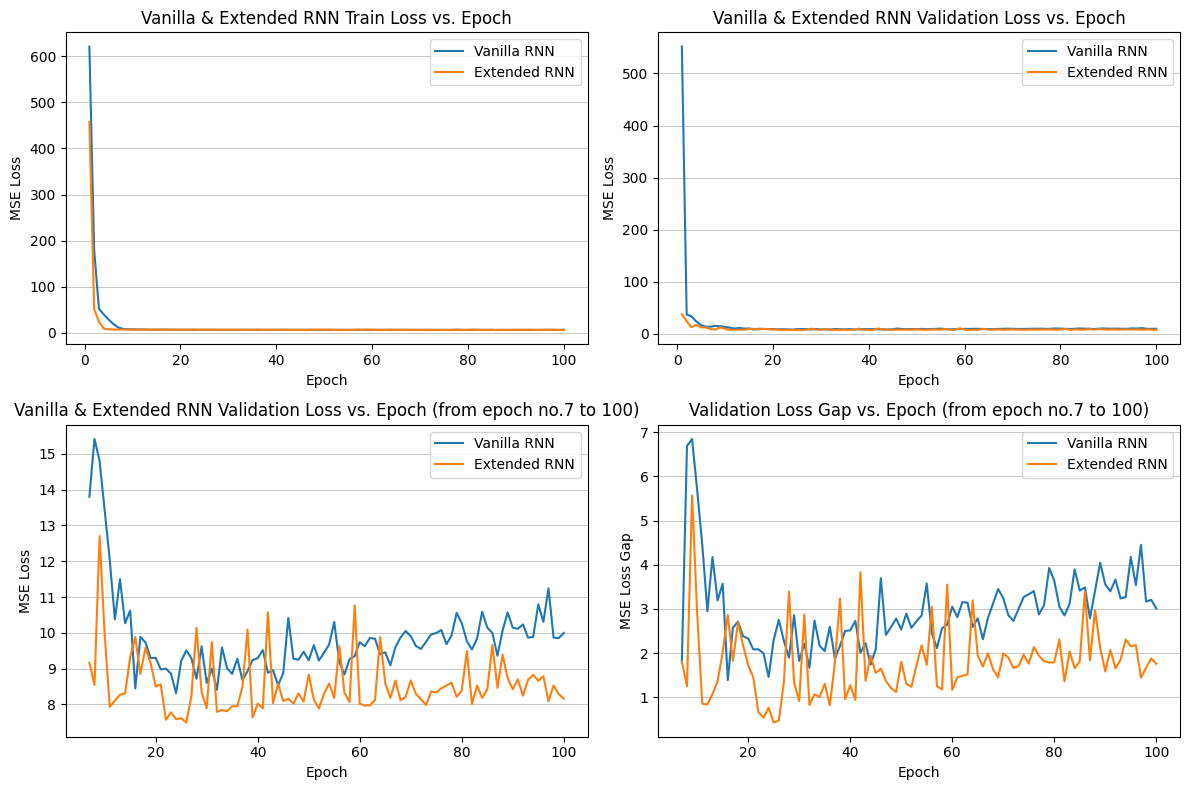

In [21]:
# Creating 1x2 subplots
fig, ((ax5, ax7), (ax1, ax3)) = plt.subplots(2, 2, figsize=(12,8))

# Plotting baseline & vanilla rnn train loss on the left side
# ax6 = ax5.twinx()
lns5 = ax5.plot(range(1, epochs+1), vanilla_rnn_epoch_train_loss, label="Vanilla RNN")
lns6 = ax5.plot(range(1, epochs+1), extended_rnn_epoch_train_loss, label="Extended RNN")
ax5.set_xlabel("Epoch")
ax5.set_ylabel("MSE Loss")
lns = lns5 + lns6
labs = [l.get_label() for l in lns]
ax5.legend(lns, labs, loc=0)
ax5.set_title("Vanilla & Extended RNN Train Loss vs. Epoch")
ax5.grid(linewidth=0.5, axis="y")

# Plotting baseline & vanilla rnn validation loss on the left side
# ax8 = ax7.twinx()
lns7 = ax7.plot(range(1, epochs+1), vanilla_rnn_epoch_val_loss, label="Vanilla RNN")
lns8 = ax7.plot(range(1, epochs+1), extended_rnn_epoch_val_loss, label="Extended RNN")
ax7.set_xlabel("Epoch")
ax7.set_ylabel("MSE Loss")
lns = lns7 + lns8
labs = [l.get_label() for l in lns]
ax7.legend(lns, labs, loc=0)
ax7.set_title("Vanilla & Extended RNN Validation Loss vs. Epoch")
ax7.grid(linewidth=0.5, axis="y")

# Plotting baseline loss on the left side
# ax2 = ax1.twinx()
min_epochs, max_epochs = 7, epochs
lns1 = ax1.plot(range(min_epochs, max_epochs+1), vanilla_rnn_epoch_val_loss[min_epochs-1:max_epochs], label="Vanilla RNN")
lns2 = ax1.plot(range(min_epochs, max_epochs+1), extended_rnn_epoch_val_loss[min_epochs-1:max_epochs], label="Extended RNN")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_title("Vanilla & Extended RNN Validation Loss vs. Epoch (from epoch no.%s to %s)" % (min_epochs, max_epochs))
ax1.grid(linewidth=0.5, axis="y")

# Plotting vanilla rnn loss on the right side
# ax4 = ax3.twinx()
lns3 = ax3.plot(range(min_epochs, max_epochs+1), np.asarray(vanilla_rnn_epoch_val_loss[min_epochs-1:max_epochs]) \
                                               - np.asarray(vanilla_rnn_epoch_train_loss[min_epochs-1:max_epochs]), label="Vanilla RNN")
lns4 = ax3.plot(range(min_epochs, max_epochs+1), np.asarray(extended_rnn_epoch_val_loss[min_epochs-1:max_epochs]) \
                                               - np.asarray(extended_rnn_epoch_train_loss[min_epochs-1:max_epochs]), label="Extended RNN")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("MSE Loss Gap")
lns = lns3 + lns4
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.set_title("Validation Loss Gap vs. Epoch (from epoch no.%s to %s)" % (min_epochs, max_epochs))
ax3.grid(linewidth=0.5, axis="y")

plt.tight_layout()
plt.show()

__WRITTEN ANSWER Experiment conclusion__: My hypothesis that swapping to a non-linear MLP head can enhance the capability of the model was correct based on the experimental results shown above. According to the top 2 figures, both the trianing and validation losses of the Extended RNN are lower than those of the Vanilla RNN. According to the more detailed results shown in the bottom 2 figures, the training loss was reduced around **20%** while the best validation loss was reduced about **40-50**%.

## Task5: Auxiliary loss
Including auxiliary loss functions is a common approach for improving the performance of machine learning models as they increase the amount of gradient signal available for updating parameters. When using an auxiliary loss, it is __critical__ to only use the non-auxiliary loss signal when comparing model performance on the overall project objective. The auxiliary losses that will be used in this coursework are:
* Prediction of 5 step values of mean pressure, humidity and windspeed, herein referred to as __aug-aux-loss__ and;
* Prediction of 1 step values of mean temperature, for each time point in the look back, herein referred to as __inter-aux-loss__;

__Exercise 5.1__: (3 marks)
* The PandasTsDataset and ExtendedRNN class are already able to define a model that uses the __aug-aux-loss__. In the code block below define and run an experiment which implements the following:
    * An RNN with hidden dimension 64;
    * An MLP with a single hidden layer of dimension 32 and relu non-linear activation functions;
    * __aug-aux-loss__ auxiliary loss function

All other hyperparameters should be identical to those defined for the ```VanillaRNN``` model.

_Hint_:
* As in exercise 4.2, it is strongly recommended that you define all required objects for the experiment in a single code block.
* Don't worry if this model doesn't perform well!

In [22]:
wandb_name="aug-aux-rnn"
# Your code here
train_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTrain.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTest.csv"))
date_var = "date"
train_df[date_var] = pd.to_datetime(train_df[date_var], format="%Y-%m-%d")

# Dynamically select remaining columns
non_date_vars = [col for col in train_df.columns if col != date_var]
trgt_cols = ['meanpressure_5_step', 'humidity_5_step', 'wind_speed_5_step']
# For the training and test set, create a new column per non-date variable for each step number in "steps"
steps = [1,5,10]
for df in [train_df, test_df]:
    for stp in steps:
        df[[f"{col}_{stp}_step" for col in non_date_vars]] = df[non_date_vars].shift(-1*stp)
train_df["__date_yrs"] = train_df["date"].dt.year
# Visualise time periods covered by the training data
print(train_df["__date_yrs"].value_counts())

# Select the time period for the holdout set
val_idx = train_df["__date_yrs"] >= 2016
val_df = train_df[val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
train_df = train_df[~val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])

train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[trgt_cols], lookback=lookback)
val_idx = val_df[trgt_cols].isna().sum(axis=1) == 0
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_cols], lookback=lookback)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

lookback = 2
input_dim = 4
shuffle = True
batch_size = 16
lr = 1e-3
epochs = 100
fc_output_size = 3

fc_head_layers = [hidden_dim, int(hidden_dim / 2), fc_output_size]

wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "nonlinearity": nonlinearity,
    "fc_output_size": fc_output_size,
    "fc_head_layers": fc_head_layers
}

model = ExtendedRNN(
    input_dim=input_dim,  rnn_hidden_dim=wandb_config["hidden_dim"],
    rnn_num_layers=wandb_config["num_layers"],
    fc_head_layers=wandb_config["fc_head_layers"],
    nonlinearity=wandb_config["nonlinearity"]
)

first_batch = next(train_loader.__iter__())
with torch.no_grad():
    print(first_batch[0].shape)
    print(model(first_batch[1]).shape)

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name=wandb_name, wandb_config=wandb_config, debug=False
)
aug_aux_rnn_epoch_train_loss, aug_aux_rnn_epoch_val_loss = epoch_train_loss, epoch_val_loss
# Your code here - END

2016    366
2013    365
2014    365
2015    365
2017      1
Name: __date_yrs, dtype: int64
torch.Size([16, 3])
torch.Size([16, 3])


Running training epoch


69it [00:00, 207.38it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 3])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
23it [00:00, 711.02it/s]


Running validation
Running training epoch


69it [00:00, 305.34it/s]
23it [00:00, 1026.56it/s]


Running validation
Running training epoch


69it [00:00, 305.34it/s]
23it [00:00, 1054.85it/s]


Running validation
Running training epoch


69it [00:00, 310.29it/s]
23it [00:00, 1037.03it/s]


Running validation
Running training epoch


69it [00:00, 289.34it/s]
23it [00:00, 683.40it/s]


Running validation
Running training epoch


69it [00:00, 300.02it/s]
23it [00:00, 918.59it/s]


Running validation
Running training epoch


69it [00:00, 234.66it/s]
23it [00:00, 879.77it/s]


Running validation
Running training epoch


69it [00:00, 286.17it/s]
23it [00:00, 932.18it/s]


Running validation
Running training epoch


69it [00:00, 287.27it/s]
23it [00:00, 1130.10it/s]


Running validation
Running training epoch


69it [00:00, 302.07it/s]
23it [00:00, 959.64it/s]


Running validation
Running training epoch


69it [00:00, 291.26it/s]
23it [00:00, 1009.54it/s]


Running validation
Running training epoch


69it [00:00, 273.39it/s]
23it [00:00, 1028.23it/s]


Running validation
Running training epoch


69it [00:00, 289.79it/s]
23it [00:00, 1025.11it/s]


Running validation
Running training epoch


69it [00:00, 282.98it/s]
23it [00:00, 1073.19it/s]


Running validation
Running training epoch


69it [00:00, 278.56it/s]
23it [00:00, 1064.54it/s]


Running validation
Running training epoch


69it [00:00, 300.68it/s]
23it [00:00, 938.16it/s]


Running validation
Running training epoch


69it [00:00, 292.90it/s]
23it [00:00, 1046.02it/s]


Running validation
Running training epoch


69it [00:00, 292.53it/s]
23it [00:00, 1019.76it/s]


Running validation
Running training epoch


69it [00:00, 281.93it/s]
23it [00:00, 1101.50it/s]


Running validation
Running training epoch


69it [00:00, 279.24it/s]
23it [00:00, 1026.75it/s]


Running validation
Running training epoch


69it [00:00, 274.45it/s]
23it [00:00, 1075.34it/s]


Running validation
Running training epoch


69it [00:00, 266.52it/s]
23it [00:00, 1161.65it/s]


Running validation
Running training epoch


69it [00:00, 292.74it/s]
23it [00:00, 739.92it/s]


Running validation
Running training epoch


69it [00:00, 281.74it/s]
23it [00:00, 1209.66it/s]


Running validation
Running training epoch


69it [00:00, 303.24it/s]
23it [00:00, 839.47it/s]


Running validation
Running training epoch


69it [00:00, 284.04it/s]
23it [00:00, 1034.34it/s]


Running validation
Running training epoch


69it [00:00, 288.59it/s]
23it [00:00, 1077.76it/s]


Running validation
Running training epoch


69it [00:00, 269.02it/s]
23it [00:00, 918.80it/s]


Running validation
Running training epoch


69it [00:00, 292.17it/s]
23it [00:00, 1010.23it/s]


Running validation
Running training epoch


69it [00:00, 243.23it/s]
23it [00:00, 562.91it/s]


Running validation
Running training epoch


69it [00:00, 190.84it/s]
23it [00:00, 847.45it/s]


Running validation
Running training epoch


69it [00:00, 191.47it/s]
23it [00:00, 624.13it/s]


Running validation
Running training epoch


69it [00:00, 204.09it/s]
23it [00:00, 764.65it/s]


Running validation
Running training epoch


69it [00:00, 203.19it/s]
23it [00:00, 488.05it/s]


Running validation
Running training epoch


69it [00:00, 200.97it/s]
23it [00:00, 694.89it/s]


Running validation
Running training epoch


69it [00:00, 214.78it/s]
23it [00:00, 657.32it/s]


Running validation
Running training epoch


69it [00:00, 141.41it/s]
23it [00:00, 729.79it/s]


Running validation
Running training epoch


69it [00:00, 202.63it/s]
23it [00:00, 642.73it/s]


Running validation
Running training epoch


69it [00:00, 228.70it/s]
23it [00:00, 537.56it/s]


Running validation
Running training epoch


69it [00:00, 199.39it/s]
23it [00:00, 647.54it/s]


Running validation
Running training epoch


69it [00:00, 185.75it/s]
23it [00:00, 629.43it/s]


Running validation
Running training epoch


69it [00:00, 181.31it/s]
23it [00:00, 642.92it/s]


Running validation
Running training epoch


69it [00:00, 180.34it/s]
23it [00:00, 719.16it/s]


Running validation
Running training epoch


69it [00:00, 194.19it/s]
23it [00:00, 780.20it/s]


Running validation
Running training epoch


69it [00:00, 190.47it/s]
23it [00:00, 1103.85it/s]


Running validation
Running training epoch


69it [00:00, 283.19it/s]
23it [00:00, 677.81it/s]


Running validation
Running training epoch


69it [00:00, 219.84it/s]
23it [00:00, 1083.31it/s]


Running validation
Running training epoch


69it [00:00, 296.96it/s]
23it [00:00, 907.11it/s]


Running validation
Running training epoch


69it [00:00, 301.10it/s]
23it [00:00, 1053.10it/s]


Running validation
Running training epoch


69it [00:00, 287.43it/s]
23it [00:00, 929.79it/s]


Running validation
Running training epoch


69it [00:00, 280.88it/s]
23it [00:00, 924.26it/s]


Running validation
Running training epoch


69it [00:00, 289.35it/s]
23it [00:00, 1118.79it/s]


Running validation
Running training epoch


69it [00:00, 292.20it/s]
23it [00:00, 1018.66it/s]


Running validation
Running training epoch


69it [00:00, 281.38it/s]
23it [00:00, 1032.28it/s]


Running validation
Running training epoch


69it [00:00, 295.46it/s]
23it [00:00, 961.44it/s]


Running validation
Running training epoch


69it [00:00, 297.26it/s]
23it [00:00, 986.24it/s]


Running validation
Running training epoch


69it [00:00, 296.79it/s]
23it [00:00, 756.23it/s]


Running validation
Running training epoch


69it [00:00, 281.18it/s]
23it [00:00, 1114.95it/s]


Running validation
Running training epoch


69it [00:00, 301.41it/s]
23it [00:00, 624.82it/s]


Running validation
Running training epoch


69it [00:00, 299.52it/s]
23it [00:00, 746.28it/s]


Running validation
Running training epoch


69it [00:00, 272.91it/s]
23it [00:00, 1013.38it/s]


Running validation
Running training epoch


69it [00:00, 286.70it/s]
23it [00:00, 1098.76it/s]


Running validation
Running training epoch


69it [00:00, 287.57it/s]
23it [00:00, 1189.87it/s]


Running validation
Running training epoch


69it [00:00, 292.78it/s]
23it [00:00, 1021.44it/s]


Running validation
Running training epoch


69it [00:00, 289.16it/s]
23it [00:00, 952.13it/s]


Running validation
Running training epoch


69it [00:00, 293.88it/s]
23it [00:00, 1010.83it/s]


Running validation
Running training epoch


69it [00:00, 272.90it/s]
23it [00:00, 1169.32it/s]


Running validation
Running training epoch


69it [00:00, 290.97it/s]
23it [00:00, 990.70it/s]


Running validation
Running training epoch


69it [00:00, 304.20it/s]
23it [00:00, 912.18it/s]


Running validation
Running training epoch


69it [00:00, 297.12it/s]
23it [00:00, 900.86it/s]


Running validation
Running training epoch


69it [00:00, 290.75it/s]
23it [00:00, 652.66it/s]


Running validation
Running training epoch


69it [00:00, 299.69it/s]
23it [00:00, 939.76it/s]


Running validation
Running training epoch


69it [00:00, 315.55it/s]
23it [00:00, 1150.48it/s]


Running validation
Running training epoch


69it [00:00, 286.19it/s]
23it [00:00, 1060.12it/s]


Running validation
Running training epoch


69it [00:00, 267.77it/s]
23it [00:00, 1087.65it/s]


Running validation
Running training epoch


69it [00:00, 283.67it/s]
23it [00:00, 1073.57it/s]


Running validation
Running training epoch


69it [00:00, 291.96it/s]
23it [00:00, 934.10it/s]


Running validation
Running training epoch


69it [00:00, 293.92it/s]
23it [00:00, 993.13it/s]


Running validation
Running training epoch


69it [00:00, 211.47it/s]
23it [00:00, 718.51it/s]


Running validation
Running training epoch


69it [00:00, 206.42it/s]
23it [00:00, 738.26it/s]


Running validation
Running training epoch


69it [00:00, 190.26it/s]
23it [00:00, 556.74it/s]


Running validation
Running training epoch


69it [00:00, 191.58it/s]
23it [00:00, 815.94it/s]


Running validation
Running training epoch


69it [00:00, 199.22it/s]
23it [00:00, 713.13it/s]


Running validation
Running training epoch


69it [00:00, 192.00it/s]
23it [00:00, 808.52it/s]


Running validation
Running training epoch


69it [00:00, 170.29it/s]
23it [00:00, 84.15it/s]


Running validation
Running training epoch


69it [00:01, 68.68it/s] 
23it [00:00, 767.22it/s]


Running validation
Running training epoch


69it [00:01, 57.31it/s]
23it [00:00, 618.38it/s]


Running validation
Running training epoch


69it [00:00, 191.12it/s]
23it [00:00, 525.11it/s]


Running validation
Running training epoch


69it [00:00, 185.63it/s]
23it [00:00, 686.92it/s]


Running validation
Running training epoch


69it [00:00, 234.40it/s]
23it [00:00, 1193.72it/s]


Running validation
Running training epoch


69it [00:00, 281.73it/s]
23it [00:00, 1088.03it/s]


Running validation
Running training epoch


69it [00:00, 288.23it/s]
23it [00:00, 937.80it/s]


Running validation
Running training epoch


69it [00:00, 302.58it/s]
23it [00:00, 907.24it/s]


Running validation
Running training epoch


69it [00:00, 288.86it/s]
23it [00:00, 1226.00it/s]


Running validation
Running training epoch


69it [00:00, 289.89it/s]
23it [00:00, 992.28it/s]


Running validation
Running training epoch


69it [00:00, 281.83it/s]
23it [00:00, 926.86it/s]


Running validation
Running training epoch


69it [00:00, 277.71it/s]
23it [00:00, 1005.08it/s]


Running validation
Running training epoch


69it [00:00, 287.08it/s]
23it [00:00, 1115.24it/s]


Running validation
Running training epoch


69it [00:00, 280.61it/s]
23it [00:00, 1102.81it/s]


Running validation
Running training epoch


69it [00:00, 224.76it/s]
23it [00:00, 1013.29it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████████████
train_loss,110.13569
val_loss,662327.34239


__Exercise 5.2__: (7 marks)
* In order to implement train an RNN model which includes the __inter-aux-loss__, a new dataset object and Pytorch model class must be defined. These have been started for you below however, you need to complete the code blocks.

_Hint_:
* This model _should_ perform the best!
* ```PandasTsDataset1StepAux```:
    * The dataset class requires an additional input namely a pandas dataframe ```y_1_step``` that should contain the 1 step values
    * The only change that needs to be made is to the ```get_lookback``` method however, the method still only adds values to the ```self._y``` and ```self._X```. How might the ```self.y_1_step``` tensor be incorporated?
* ```AugInterAuxRNN```:
    * In the ```forward``` method of the ```ExtendedRNN```, the logic ```if not self.training:``` defines how the forward pass is altered when ```model.eval()``` is called (this is called within the ```validate``` function at the beginning of the notebook).
    * Note that in the experiment definintion below, a dataset of type ```PandasTsDataset1StepAux``` is used to define the training dataset whilst a dataset of type ```PandasTsDataset``` is used to define the validation set. How should the model output alter to adjust to this?

In [23]:
class PandasTsDataset1StepAux(PandasDataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, y_1_step:pd.DataFrame, lookback:int, normalise:bool=True)->None:
        self.y_1_step = torch.from_numpy(y_1_step.values).float()
        # Call super so that the PandasDataset.__init__ function is called
        super().__init__(X=X, y=y, normalise=normalise)
        if lookback > 1:
            self.get_lookback(lookback=lookback)
        self._len = self._X.shape[0]


    def get_lookback(self, lookback:int):
        X_vals = []
        y_vals = []
        # Your code here
        for i in range(self._X.shape[0]-(lookback-1)):
            X_vals.append(self._X[i:i+lookback][None, :])
            y_vals.append(torch.concat((self._y[i+lookback-1],
                                        self.y_1_step[i+lookback-1]))[None, :])
        # Your code here - END
        self._y = torch.concat(y_vals, axis=0)
        self._X = torch.concat(X_vals, axis=0)


class AugInterAuxRNN(ExtendedRNN):

    def __init__(
        self, input_dim:int,  rnn_hidden_dim:int, rnn_num_layers:int,
        fc_head_layers:List[int], fc_inter_head_layers:List[int],
        nonlinearity:str
    ) -> None:
        super().__init__(
            input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim,
            rnn_num_layers=rnn_num_layers, fc_head_layers=fc_head_layers,
            nonlinearity=nonlinearity
        )
        self.fc_inter = nn.ModuleList()
        fc_inter_head_layers = [rnn_hidden_dim, *fc_inter_head_layers]
        for i in range(len(fc_inter_head_layers)-1):
            self.fc_inter.append(nn.Linear(
                in_features=fc_inter_head_layers[i],
                out_features=fc_inter_head_layers[i+1]
            ))
            if i < len(fc_inter_head_layers)-2:
                self.fc_inter.append(self.fc_non_linear)

    def forward(self, x):
        # Your code here
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        out = out[1].squeeze()

        fc_out = self.fc[0](out)
        for layer in self.fc[1:]:
            fc_out = layer(fc_out)

        if self.training:
            fc_inter_out = self.fc_inter[0](out)
            for layer in self.fc_inter[1:]:
                fc_inter_out = layer(fc_inter_out)
            out = torch.concat((fc_out, fc_inter_out), axis=1)
            return out
        else:
            return fc_out
        # Your code here - END

In [24]:
input_dim = 4
lr = 0.001
lookback = 2
hidden_dim = 64
num_layers = 1
fc_head_layers = [32,1]
fc_inter_head_layers = [32,1]
nonlinearity = "relu"
shuffle = True
batch_size = 32
epochs = 100

trgt_cols = ["meantemp_5_step"]
display(train_df[non_date_vars+trgt_cols+["meantemp_1_step"]].head())
train_dataset = PandasTsDataset1StepAux(
    X=train_df[non_date_vars],
    y = train_df[trgt_cols],
    y_1_step=train_df[["meantemp_1_step"]],
    lookback=2,
    normalise=True # MODIFIED: enable normalisation here
)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
print(f"First observation X:\n{train_dataset[0][1]}")
print(f"First observation y:\n{train_dataset[0][0]}")
print("\n")

print(f"Second observation X:\n{train_dataset[1][1]}")
print(f"Second observation y:\n{train_dataset[1][0]}")

val_idx = val_df[trgt_cols].isna().sum(axis=1) == 0
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "fc_head_layers": fc_head_layers,
    "fc_inter_head_layers": fc_inter_head_layers,
    "nonlinearity": nonlinearity
}

model = AugInterAuxRNN(
    input_dim=input_dim, rnn_hidden_dim=wandb_config["hidden_dim"],
    rnn_num_layers=wandb_config["num_layers"],
    fc_head_layers=wandb_config["fc_head_layers"],
    fc_inter_head_layers=wandb_config["fc_inter_head_layers"],
    nonlinearity=wandb_config["nonlinearity"]
)

# Check model is predicting
with torch.no_grad():
    model.train()
    first_batch = next(train_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

    model.eval()
    first_batch = next(val_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="inter-aug-aux-rnn", wandb_config=wandb_config, debug=False
)

,meantemp,humidity,wind_speed,meanpressure,meantemp_5_step,meantemp_1_step
0,10.000000,84.500000,0.000000,1015.666667,7.000000,7.400000
1,7.400000,92.000000,2.980000,1017.800000,7.000000,7.166667
2,7.166667,87.000000,4.633333,1018.666667,8.857143,8.666667
3,8.666667,71.333333,1.233333,1017.166667,14.000000,6.000000
4,6.000000,86.833333,3.700000,1016.500000,11.000000,7.000000


First observation X:
tensor([[0.1223, 0.8404, 0.0000, 0.7681],
        [0.0428, 0.9291, 0.0706, 0.8356]])
First observation y:
tensor([7.0000, 7.1667])


Second observation X:
tensor([[0.0428, 0.9291, 0.0706, 0.8356],
        [0.0357, 0.8699, 0.1097, 0.8630]])
Second observation y:
tensor([8.8571, 8.6667])
first_batch res shape: torch.Size([32, 2])
res shape: torch.Size([32, 2])
first_batch res shape: torch.Size([32, 1])
res shape: torch.Size([32, 1])


Running training epoch


35it [00:00, 73.38it/s]
12it [00:00, 588.23it/s]


Running validation
Running training epoch


35it [00:00, 159.07it/s]
12it [00:00, 502.53it/s]


Running validation
Running training epoch


35it [00:00, 151.33it/s]
12it [00:00, 551.85it/s]


Running validation
Running training epoch


35it [00:00, 137.64it/s]
12it [00:00, 301.77it/s]


Running validation
Running training epoch


35it [00:00, 157.98it/s]
12it [00:00, 421.91it/s]


Running validation
Running training epoch


35it [00:00, 123.91it/s]
12it [00:00, 239.78it/s]


Running validation
Running training epoch


35it [00:00, 124.05it/s]
12it [00:00, 498.26it/s]


Running validation
Running training epoch


35it [00:00, 165.88it/s]
12it [00:00, 552.45it/s]


Running validation
Running training epoch


35it [00:00, 166.89it/s]
12it [00:00, 602.72it/s]


Running validation
Running training epoch


35it [00:00, 154.46it/s]
12it [00:00, 372.41it/s]


Running validation
Running training epoch


35it [00:00, 174.11it/s]
12it [00:00, 603.91it/s]


Running validation
Running training epoch


35it [00:00, 176.85it/s]
12it [00:00, 606.87it/s]


Running validation
Running training epoch


35it [00:00, 162.22it/s]
12it [00:00, 421.63it/s]


Running validation
Running training epoch


35it [00:00, 152.51it/s]
12it [00:00, 598.24it/s]


Running validation
Running training epoch


35it [00:00, 161.78it/s]
12it [00:00, 630.74it/s]


Running validation
Running training epoch


35it [00:00, 150.50it/s]
12it [00:00, 417.37it/s]


Running validation
Running training epoch


35it [00:00, 147.31it/s]
12it [00:00, 445.00it/s]


Running validation
Running training epoch


35it [00:00, 158.48it/s]
12it [00:00, 541.01it/s]


Running validation
Running training epoch


35it [00:00, 155.77it/s]
12it [00:00, 544.92it/s]


Running validation
Running training epoch


35it [00:00, 151.51it/s]
12it [00:00, 525.90it/s]


Running validation
Running training epoch


35it [00:00, 150.28it/s]
12it [00:00, 535.24it/s]


Running validation
Running training epoch


35it [00:00, 184.43it/s]
12it [00:00, 735.03it/s]


Running validation
Running training epoch


35it [00:00, 232.09it/s]
12it [00:00, 674.43it/s]


Running validation
Running training epoch


35it [00:00, 245.94it/s]
12it [00:00, 799.96it/s]


Running validation
Running training epoch


35it [00:00, 247.70it/s]
12it [00:00, 866.22it/s]


Running validation
Running training epoch


35it [00:00, 215.08it/s]
12it [00:00, 783.84it/s]


Running validation
Running training epoch


35it [00:00, 217.00it/s]
12it [00:00, 821.18it/s]


Running validation
Running training epoch


35it [00:00, 245.93it/s]
12it [00:00, 728.63it/s]


Running validation
Running training epoch


35it [00:00, 238.28it/s]
12it [00:00, 791.75it/s]


Running validation
Running training epoch


35it [00:00, 236.79it/s]
12it [00:00, 785.33it/s]


Running validation
Running training epoch


35it [00:00, 192.97it/s]
12it [00:00, 871.50it/s]


Running validation
Running training epoch


35it [00:00, 239.82it/s]
12it [00:00, 744.91it/s]


Running validation
Running training epoch


35it [00:00, 217.05it/s]
12it [00:00, 700.42it/s]


Running validation
Running training epoch


35it [00:00, 243.32it/s]
12it [00:00, 820.99it/s]


Running validation
Running training epoch


35it [00:00, 226.52it/s]
12it [00:00, 781.90it/s]

Running validation


Running training epoch


35it [00:00, 216.42it/s]
12it [00:00, 807.52it/s]


Running validation
Running training epoch


35it [00:00, 237.98it/s]
12it [00:00, 833.91it/s]


Running validation
Running training epoch


35it [00:00, 242.37it/s]
12it [00:00, 775.12it/s]


Running validation
Running training epoch


35it [00:00, 247.75it/s]
12it [00:00, 888.94it/s]


Running validation
Running training epoch


35it [00:00, 251.13it/s]
12it [00:00, 825.85it/s]


Running validation
Running training epoch


35it [00:00, 216.19it/s]
12it [00:00, 824.61it/s]


Running validation
Running training epoch


35it [00:00, 252.57it/s]
12it [00:00, 717.82it/s]


Running validation
Running training epoch


35it [00:00, 239.59it/s]
12it [00:00, 768.61it/s]


Running validation
Running training epoch


35it [00:00, 249.73it/s]
12it [00:00, 770.54it/s]


Running validation
Running training epoch


35it [00:00, 234.54it/s]
12it [00:00, 728.14it/s]

Running validation
Running training epoch

35it [00:00, 231.66it/s]
12it [00:00, 850.05it/s]

Running validation


Running training epoch


35it [00:00, 253.69it/s]
12it [00:00, 549.53it/s]


Running validation
Running training epoch


35it [00:00, 246.37it/s]
12it [00:00, 755.00it/s]

Running validation


Running training epoch


35it [00:00, 240.74it/s]
12it [00:00, 798.46it/s]

Running validation


Running training epoch


35it [00:00, 249.65it/s]
12it [00:00, 683.80it/s]


Running validation
Running training epoch


35it [00:00, 191.23it/s]
12it [00:00, 577.58it/s]


Running validation
Running training epoch


35it [00:00, 246.09it/s]
12it [00:00, 784.01it/s]


Running validation
Running training epoch


35it [00:00, 219.50it/s]
12it [00:00, 728.57it/s]


Running validation
Running training epoch


35it [00:00, 248.85it/s]
12it [00:00, 701.53it/s]


Running validation
Running training epoch


35it [00:00, 254.47it/s]
12it [00:00, 776.22it/s]


Running validation
Running training epoch


35it [00:00, 214.36it/s]
12it [00:00, 753.48it/s]


Running validation
Running training epoch


35it [00:00, 241.77it/s]
12it [00:00, 781.23it/s]


Running validation
Running training epoch


35it [00:00, 240.64it/s]
12it [00:00, 742.21it/s]


Running validation
Running training epoch


35it [00:00, 249.92it/s]
12it [00:00, 713.78it/s]


Running validation
Running training epoch


35it [00:00, 244.66it/s]
12it [00:00, 591.69it/s]

Running validation


Running training epoch


35it [00:00, 213.03it/s]
12it [00:00, 605.46it/s]


Running validation
Running training epoch


35it [00:00, 233.76it/s]
12it [00:00, 783.86it/s]


Running validation
Running training epoch


35it [00:00, 242.03it/s]
12it [00:00, 740.39it/s]


Running validation
Running training epoch


35it [00:00, 238.56it/s]
12it [00:00, 539.15it/s]


Running validation
Running training epoch


35it [00:00, 195.55it/s]
12it [00:00, 479.51it/s]


Running validation
Running training epoch


35it [00:00, 217.10it/s]
12it [00:00, 667.77it/s]


Running validation
Running training epoch


35it [00:00, 247.21it/s]
12it [00:00, 789.23it/s]


Running validation
Running training epoch


35it [00:00, 221.45it/s]
12it [00:00, 710.72it/s]


Running validation
Running training epoch


35it [00:00, 237.46it/s]
12it [00:00, 714.54it/s]


Running validation
Running training epoch


35it [00:00, 224.74it/s]
12it [00:00, 690.79it/s]

Running validation


Running training epoch


35it [00:00, 185.94it/s]
12it [00:00, 623.92it/s]


Running validation
Running training epoch


35it [00:00, 143.89it/s]
12it [00:00, 405.24it/s]


Running validation
Running training epoch


35it [00:00, 154.88it/s]
12it [00:00, 630.63it/s]


Running validation
Running training epoch


35it [00:00, 175.22it/s]
12it [00:00, 623.30it/s]


Running validation
Running training epoch


35it [00:00, 169.34it/s]
12it [00:00, 571.81it/s]


Running validation
Running training epoch


35it [00:00, 173.60it/s]
12it [00:00, 635.49it/s]


Running validation
Running training epoch


35it [00:00, 177.12it/s]
12it [00:00, 583.44it/s]


Running validation
Running training epoch


35it [00:00, 170.59it/s]
12it [00:00, 449.41it/s]


Running validation
Running training epoch


35it [00:00, 137.36it/s]
12it [00:00, 530.39it/s]


Running validation
Running training epoch


35it [00:00, 156.15it/s]
12it [00:00, 562.14it/s]


Running validation
Running training epoch


35it [00:00, 152.30it/s]
12it [00:00, 495.10it/s]


Running validation
Running training epoch


35it [00:00, 151.01it/s]
12it [00:00, 544.51it/s]


Running validation
Running training epoch


35it [00:00, 164.83it/s]
12it [00:00, 593.29it/s]


Running validation
Running training epoch


35it [00:00, 155.33it/s]
12it [00:00, 532.76it/s]


Running validation
Running training epoch


35it [00:00, 159.24it/s]
12it [00:00, 625.44it/s]


Running validation
Running training epoch


35it [00:00, 169.15it/s]
12it [00:00, 608.11it/s]


Running validation
Running training epoch


35it [00:00, 167.32it/s]
12it [00:00, 591.90it/s]


Running validation
Running training epoch


35it [00:00, 172.71it/s]
12it [00:00, 558.95it/s]


Running validation
Running training epoch


35it [00:00, 164.36it/s]
12it [00:00, 488.92it/s]


Running validation
Running training epoch


35it [00:00, 150.41it/s]
12it [00:00, 563.18it/s]


Running validation
Running training epoch


35it [00:00, 157.60it/s]
12it [00:00, 404.54it/s]


Running validation
Running training epoch


35it [00:00, 148.66it/s]
12it [00:00, 442.79it/s]


Running validation
Running training epoch


35it [00:00, 159.06it/s]
12it [00:00, 423.69it/s]


Running validation
Running training epoch


35it [00:00, 148.69it/s]
12it [00:00, 560.65it/s]


Running validation
Running training epoch


35it [00:00, 155.30it/s]
12it [00:00, 465.57it/s]


Running validation
Running training epoch


35it [00:00, 189.97it/s]
12it [00:00, 654.35it/s]


Running validation
Running training epoch


35it [00:00, 224.38it/s]
12it [00:00, 777.57it/s]


Running validation
Running training epoch


35it [00:00, 217.65it/s]
12it [00:00, 803.13it/s]


Running validation
Running training epoch


35it [00:00, 239.71it/s]
12it [00:00, 691.07it/s]


Running validation
Running training epoch


35it [00:00, 235.35it/s]
12it [00:00, 884.97it/s]


Running validation


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,5.27439
val_loss,7.88507
